In [1]:
# install.packages("GGally")
# install.packages("janitor")

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(funModeling) 
library(Hmisc)
library(GGally)
library(car)
library(janitor)
library(scales)

# **Medical Cost Prediction --- Can we accurately predict medical costs based on people’s data?**

# Introduction

Health issues can arise suddenly and unexpectedly, leading to a lot of stress for those affected. Financial stress is a big part of that; healthcare in the United States is expensive, and an issue can quickly leave a person or family running low on money. Insurance companies exist to mitigate these concerns by using financial capital to reimburse those who find themselves in such a scenario (1, 2). However, insurance companies need to collect more than they spend on the medical care of their beneficiaries in order to not lose money themselves. In order to do that, they use historical data to sufficiently and precisely measure the amount of the medical costs covered by the insurance charges of each beneficiary (1, 2). The medical insurers’ main job is to correctly anticipate insurance policy costs, develop accurate pricing models, plan a particular insurance outcome, and manage a big portfolio based on their data analysis of individual insurance records (1). 

Our dataset “Insurance.csv” is scraped from Kaggle and it contains 1,339 insurance records from the past, including age, gender, family status, Body Mass Index, smoking or not, etc. We will train a ML regression model that generates the target individual medical charges more accurately with various factors that could influence an individual's health status as model inputs. Metrics such as the coefficient of determination and the mean squared error will be used to evaluate this regression model. Additionally, we will determine what the most correlated variable influencing insurance costs is. Our final objective is to correctly predict insurance charges based on this model. The insurance company can then set the price of yearly premiums higher or lower according to our analysis results.

The variables of interest are described as followings:

age: age of primary beneficiary
sex: insurance contractor gender, female or male
bmi: Body mass index, a measure of body size that is calculated by dividing your weight in kilograms by the square of your height in metres. This calculation is a simple way of checking if a person may have weight-related health problems such as obesity.  A healthy BMI is between 18.5 and 24.9 (kg/m^2).
children: Number of children covered by health insurance / Number of dependents, usually from 0-5
smoker: indicates whether or not a person smokes
region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
charges: Individual medical costs billed by health insurance


### 2. Exploratory Data Analysis

#### 2.0 Data Pre-process
**Data downloaded from web into R**

In [45]:
data<- read.csv("https://raw.githubusercontent.com/Zibo-S/STAT301_GP_4/main/insurance.csv", header= TRUE)

**Check to make sure data is in a tidy format**

In [46]:
data%>%head(3)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.90,0,yes,southwest,16884.924
2,18,male,33.77,1,no,southeast,1725.552
3,28,male,33.00,3,no,southeast,4449.462


As we can see, our data set is in a tidy format.

**Check if there is any missing value in data set.**

In [47]:
lapply(data,length)

$age
[1] 1338

$sex
[1] 1338

$bmi
[1] 1338

$children
[1] 1338

$smoker
[1] 1338

$region
[1] 1338

$charges
[1] 1338

As we can see, there is no missing value in our data set. <br>
Then, continuous to EDA

#### 2.1 Exploratory Data Analysis 
**Split variables into categorical and numerical, then check their unique values.**

In [48]:
data%>%summary()

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

<p style="text-align: center;"> *Table $2.1.0$ Data Set Summary*

In [49]:
data_unique<- data%>% status()%>% select (unique)
data_unique

,unique
,<int>
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


<p style="text-align: center;">  *Table $2.1.1$ Variable Unique Values*

As we can see variable children only has 6 values, so it should be considered as a categorical variable. <br>
**Categorical Variables:** "sex", "children", "smoker", "region"<br>
**Numerical Variables:** "age", "bmi", "charges"<br>

Here we split the data into training set (70 $\%$) and testing set (30$\%$)

In [50]:
set.seed(1234)

data$ID <- 1:nrow(data)
training_set <- sample_n(data, size = nrow(data) * 0.70,
  replace = FALSE
)

testing_set <- anti_join(data,
  training_set,
  by = "ID"
)

head(training_set, 3)
nrow(training_set)

head(testing_set, 3)
nrow(testing_set)

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,32,male,28.12,4,yes,northwest,21472.479,1308
2,26,female,34.20,2,no,southwest,3987.926,1018
3,23,female,42.75,1,yes,northeast,40904.200,1125


[1] 936

,age,sex,bmi,children,smoker,region,charges,ID
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>
1,28,male,33.00,3,no,southeast,4449.462,3
2,32,male,28.88,0,no,northwest,3866.855,5
3,37,female,27.74,3,no,northwest,7281.506,8


[1] 402

**Check data balancing for our target variable Charges by histogram.** 

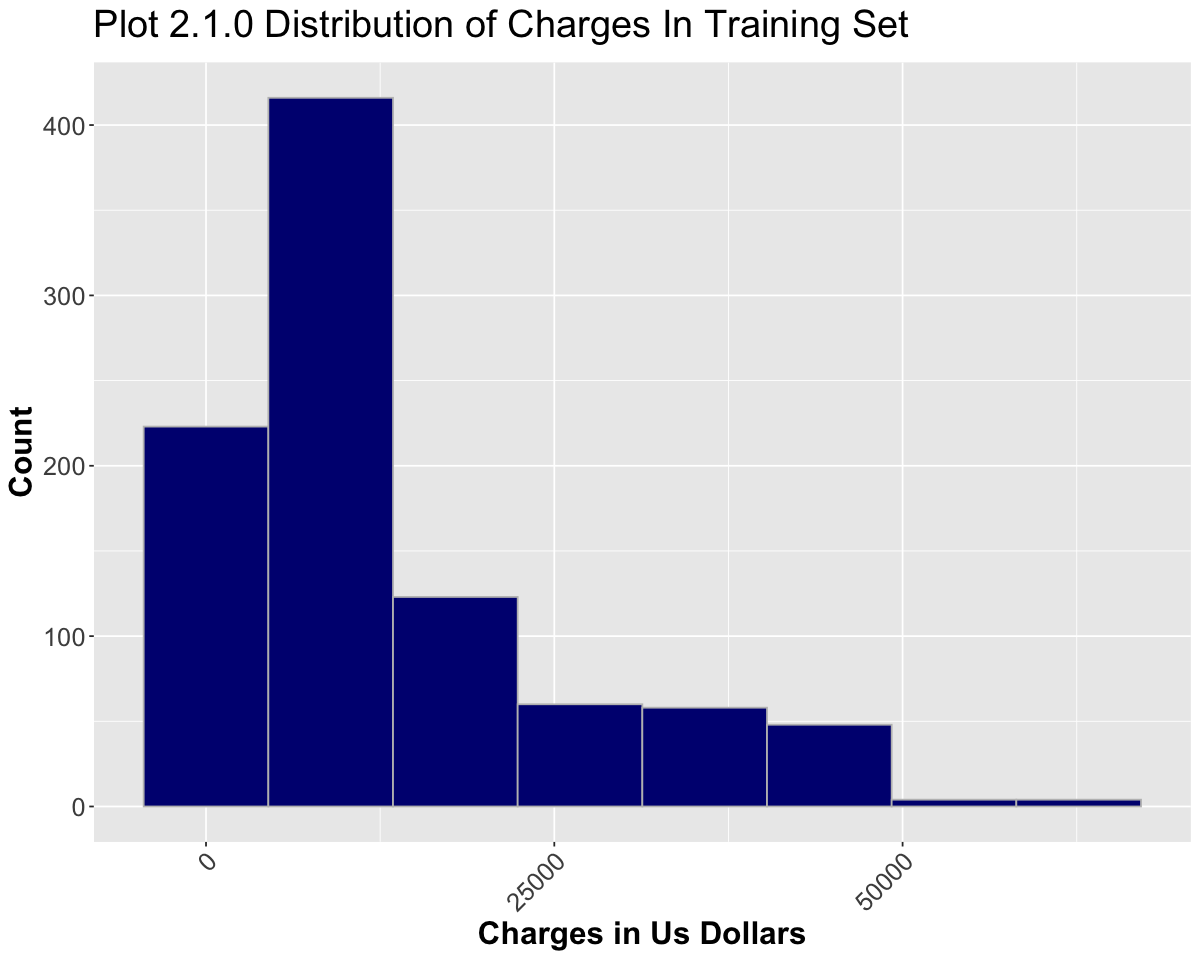

In [78]:
options(repr.plot.width = 10, repr.plot.height = 8)
hist_charges <- ggplot(training_set, aes(x = charges)) +
  geom_histogram(bins = 8, color = "gray", fill = "navyblue") +
  xlab("Charges in Us Dollars") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  ggtitle(expression("Plot 2.1.0 Distribution of Charges In Training Set"))
hist_charges

As we can see, there are less count for chargers over $25000, which make sense, since less people are being charged for higher amount. <br>

**Explore the association of the numerical explanatory variables with the target.**

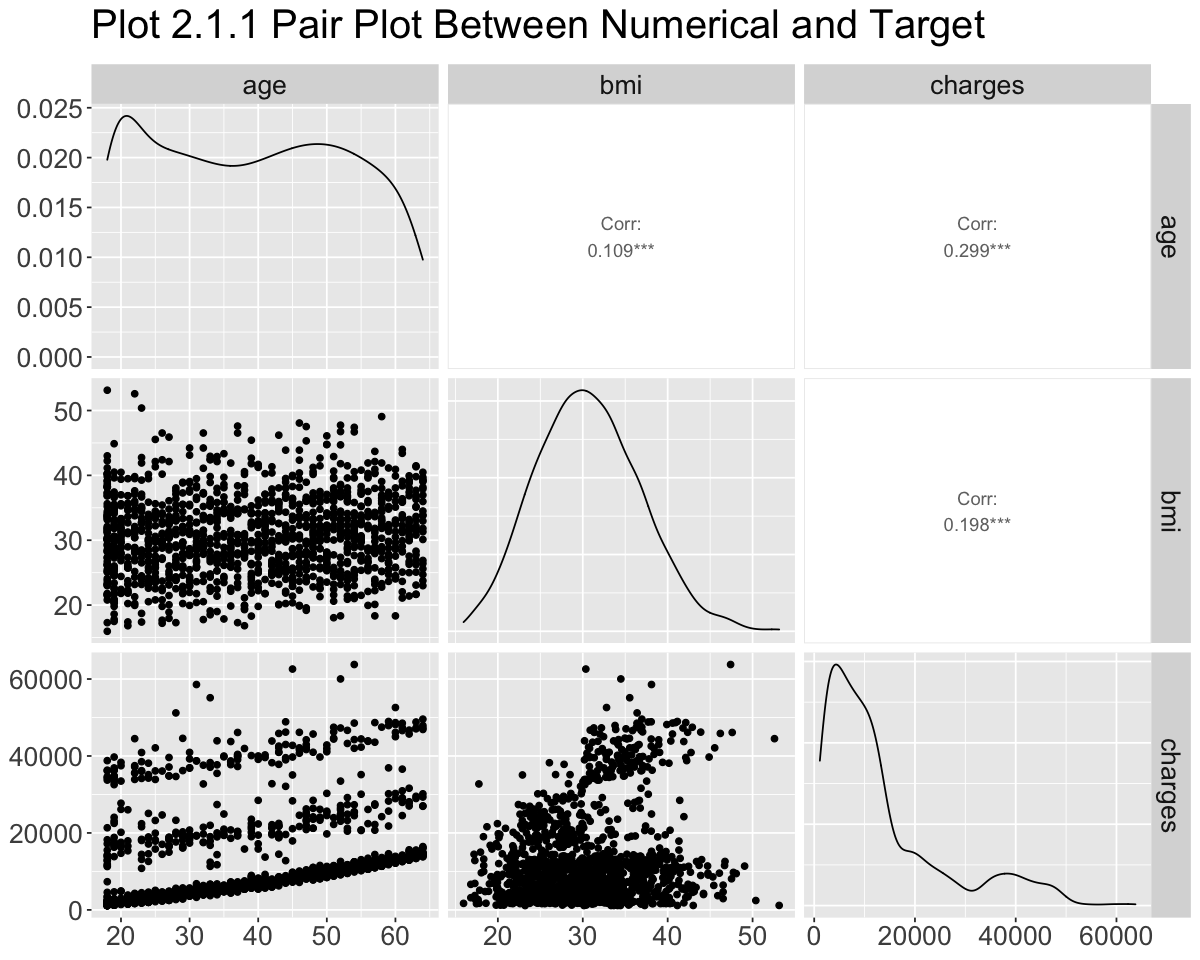

In [80]:
options(repr.plot.width = 10, repr.plot.height = 8)
contunuous_variable<- data%>%select('age','bmi','charges')%>%as.data.frame() 
# contunuous_variable
data_pair_plots_continuous  <- contunuous_variable%>%
  ggpairs() +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.1 Pair Plot Between Numerical and Target"))

data_pair_plots_continuous 

All variables are positively correlated. <br>
`age` and `charges` has the highest correlation score ($0.299$).<br>
`bmi` and `charges` has the second highest correlation score ($0.198$).<br>
`age` and `bmi` has the lowest correlation score ($0.109$).<br><br>
We can also see that charges vs age has three groups (layers), <br >and bmi vs charges has two clusters. <br>
We will dive more about this during the analysis phase later.

**As for correlation between categorical variables and target, we decide to do box plots**

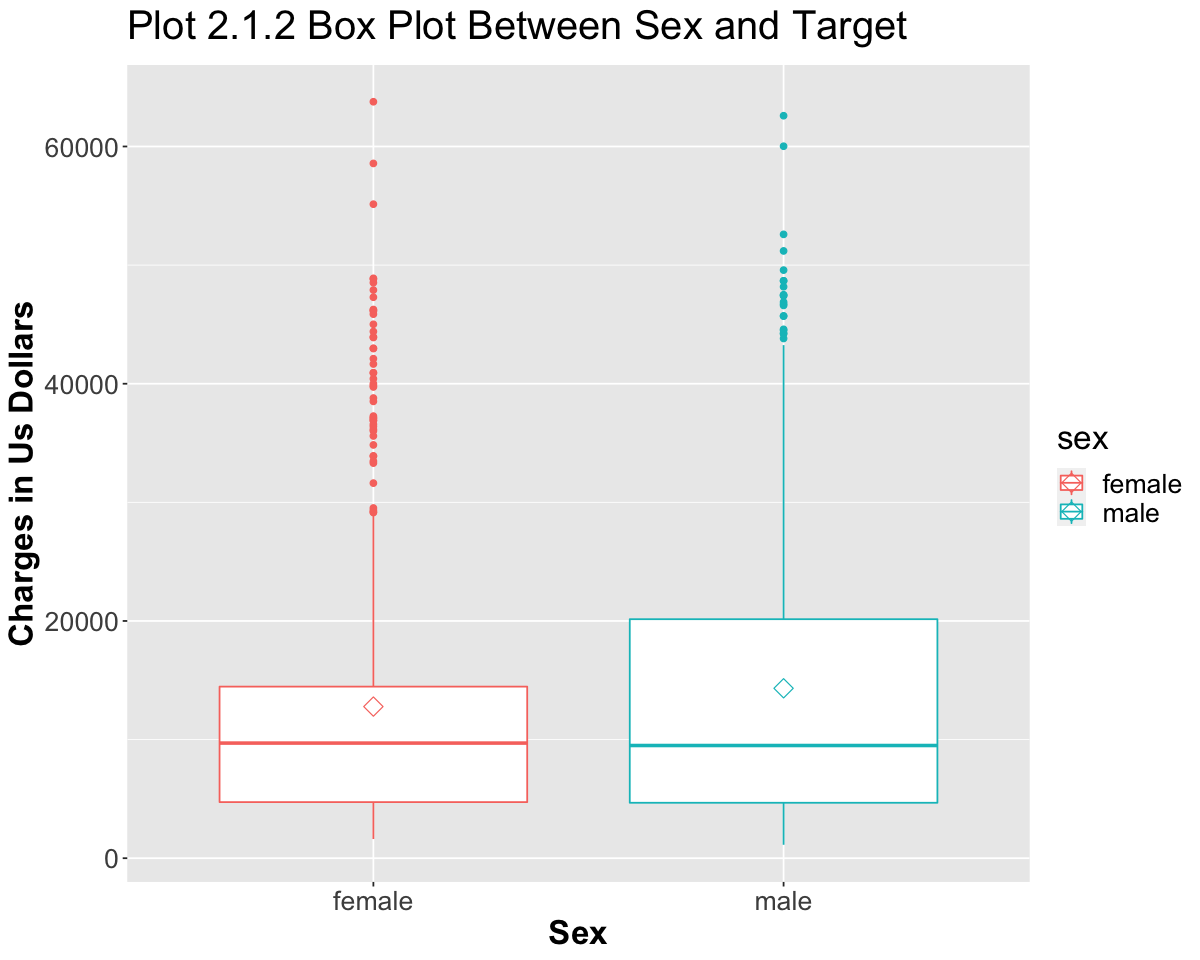

In [108]:
#"sex", "children", "smoker", "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_sex <- ggplot(training_set, aes(x=sex, y=charges,color=sex)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Sex") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.2 Box Plot Between Sex and Target"))

box_sex

From the plot above, the median of both genders are roughly the same. <br> 
However, the mean of charges of male is slighter higher than female, with less outliers<br>

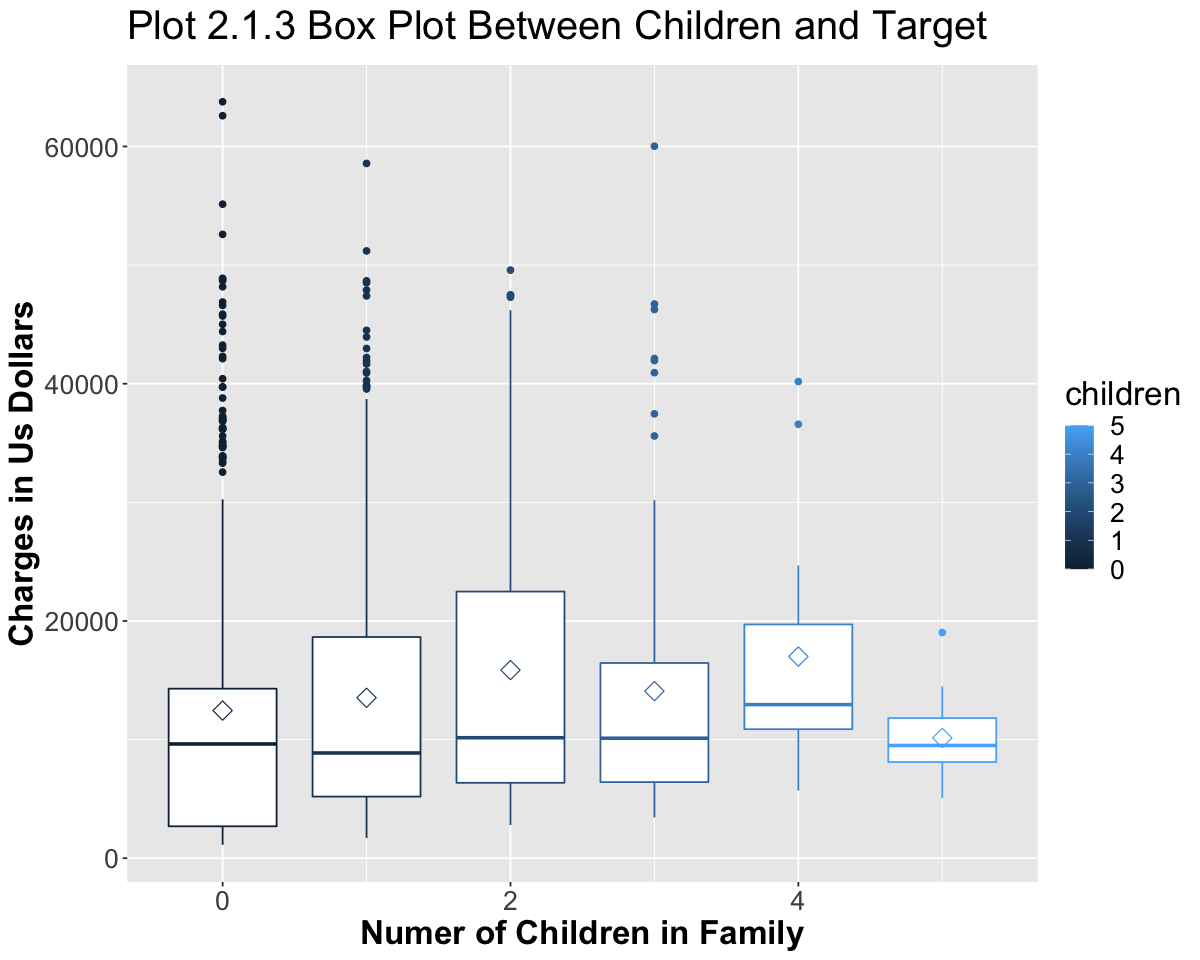

In [109]:
# "children", "smoker", "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_children <- ggplot(training_set, aes(x=children, y=charges,color=children, group=children)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Numer of Children in Family") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
  ggtitle(expression("Plot 2.1.3 Box Plot Between Children and Target"))

box_children

From the above graph, the mean of families with 4 children has the highest median, the rest groups have similar medians <br>
It seems the Q3 (75th percentile observation) of familie with 2 children is higher than the Q3 on all the rest of the family.<br>
It can be inferred that family who are paying more than $20000 are more likely to be the families with 2 children.

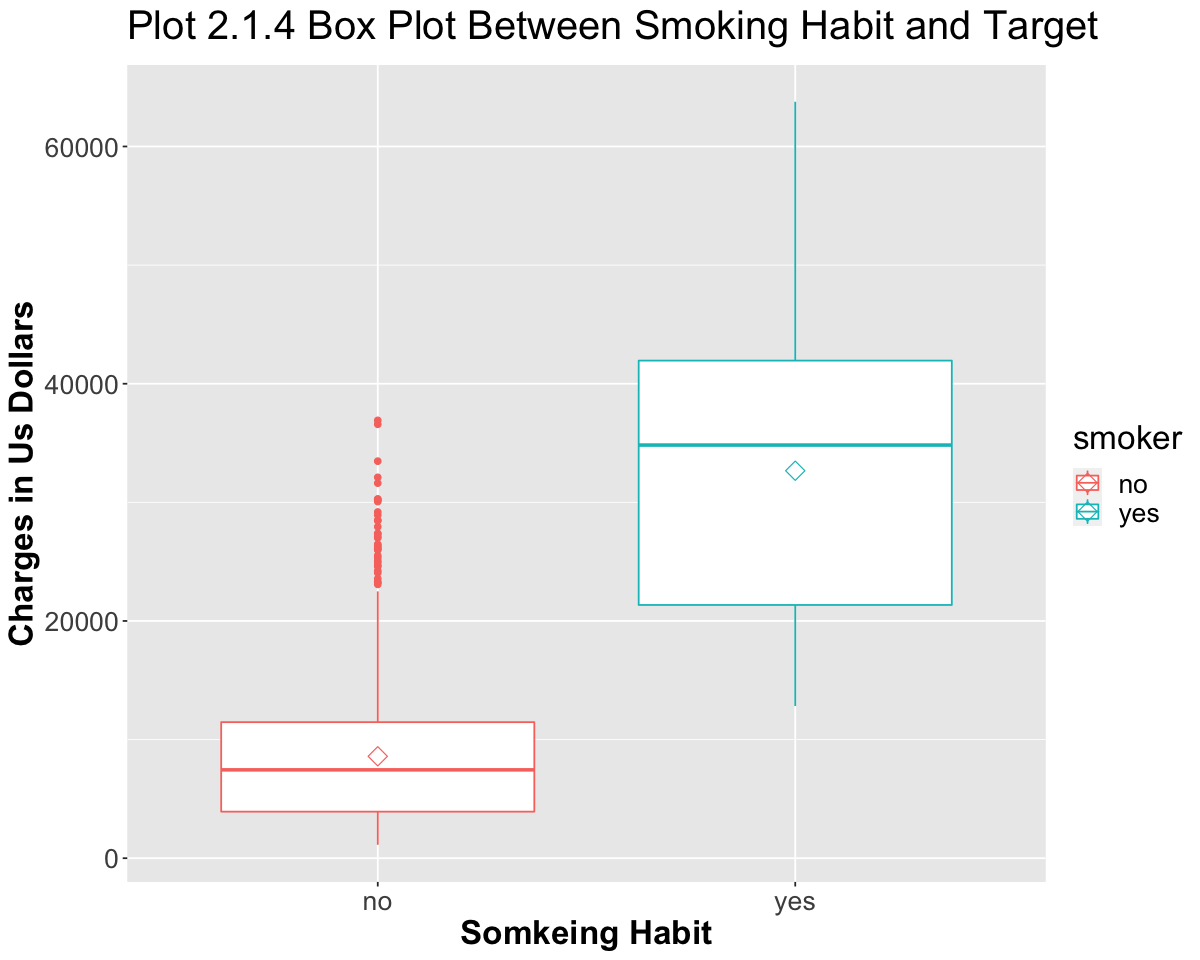

In [110]:
#  "region"
options(repr.plot.width = 10, repr.plot.height = 8)

box_smoker <- ggplot(training_set, aes(x=smoker, y=charges,color=smoker)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Somkeing Habit") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
    ggtitle(expression("Plot 2.1.4 Box Plot Between Smoking Habit and Target"))

box_smoker

From the plot above, it is obvious that smokers pay more than non-smokers

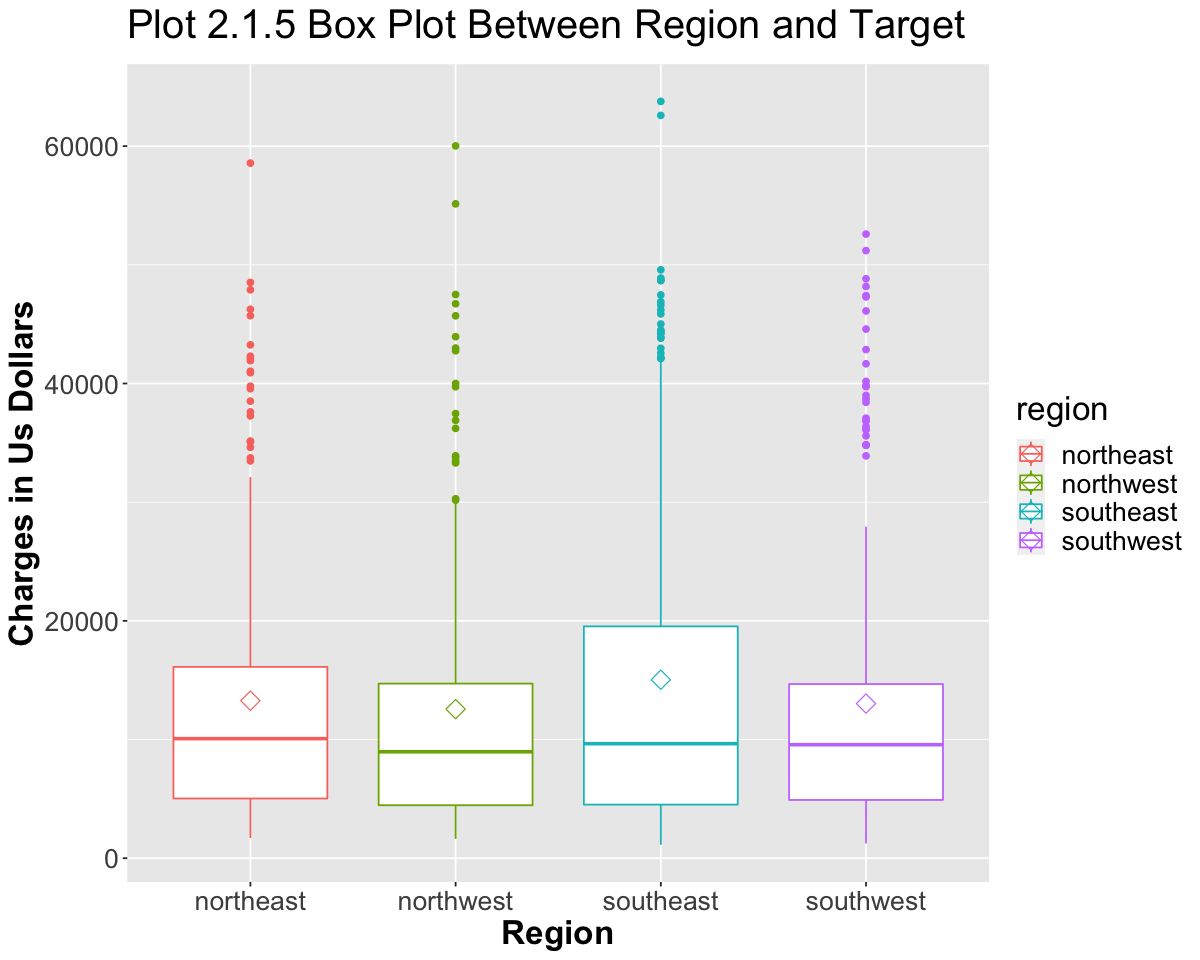

In [111]:
options(repr.plot.width = 10, repr.plot.height = 8)

box_region <- ggplot(training_set, aes(x=region, y=charges,color=region, group=region)) + 
  geom_boxplot()+ stat_summary(fun=mean, geom="point", shape=23, size=4)+
    ylab("Charges in Us Dollars") +
      xlab("Region") +
    theme(
    text = element_text(size = 20),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"))+
    ggtitle(expression("Plot 2.1.5 Box Plot Between Region and Target"))

box_region

From the above graph, the mean of families from all regions have similar median <br>
It seems the Q3 (75th percentile observation) of region Southeast is higher than the Q3 on all the rest of the regions,
but still below 20000 dollars.<br>
It can be inferred that most of families paying no more than $20000 regardless of the regions. 

**Performing a multiple linear regression by using all the variables**

In [118]:
MLR <- lm(formula = charges ~ ., data = training_set[-8])

MLR_results <- tidy(MLR) %>% mutate_if(is.numeric, round, 2)
MLR_results

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-11833.41,1214.17,-9.75,0.00
age,253.81,14.79,17.16,0.00
sexmale,-128.42,415.47,-0.31,0.76
bmi,348.28,35.61,9.78,0.00
children,519.88,176.79,2.94,0.00
smokeryes,24339.40,513.56,47.39,0.00
regionnorthwest,-207.85,597.89,-0.35,0.73
regionsoutheast,-1671.78,596.30,-2.80,0.01
regionsouthwest,-1042.73,595.11,-1.75,0.08


By using critical value = $0.05$, we can see that most of the variables are significant but `sexmale` and `regionnorthwest`.<br>
It can be inferred that these two features might not be helpful in the inference and prediction phase.

**Performing a multicollinearity check by using GVIF**<br>
GVIF is the square root of the VIF for individual predictors and thus can be used equivalently (FAQ/Collinearity - CBU Statistics Wiki, 2015).<br>
Reference: <br>
FAQ/Collinearity - CBU statistics Wiki. (2015, January). CBU Statistics Wiki. https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Collinearity

In [119]:
VIF_MLR_data<- vif(MLR)
round(VIF_MLR_data, 3)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.020,1,1.010
sex,1.014,1,1.007
bmi,1.162,1,1.078
children,1.013,1,1.006
smoker,1.015,1,1.007
region,1.157,3,1.025


<p style="text-align: center;"> *Table $2.1.2$ VIF Result*

All GVIF values are rather moderate (around 1)<br> This is not an indication of multicollinearity.

**Performing a confounding check by using F test**

In [124]:
summary(aov(MLR))

             Df    Sum Sq   Mean Sq  F value   Pr(>F)    
age           1 1.117e+10 1.117e+10  280.459  < 2e-16 ***
sex           1 5.974e+08 5.974e+08   14.999 0.000115 ***
bmi           1 4.894e+09 4.894e+09  122.872  < 2e-16 ***
children      1 4.089e+08 4.089e+08   10.266 0.001401 ** 
smoker        1 8.927e+10 8.927e+10 2241.412  < 2e-16 ***
region        3 3.850e+08 1.283e+08    3.222 0.022078 *  
Residuals   927 3.692e+10 3.983e+07                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<p style="text-align: center;"> *Table $2.1.3$ ANOVA Result*

By using p values as a criterion for the identification of confounders.<br>
By using a significance level of 0.05, since there is no p-value greater than 0.05,<br>
we can conclude that there is no obvious confounder in the model above. 

## Methods: Plan

We plan on using LASSO to fit a linear regression in order to predict the charges that someone might have to pay given different parameters. Because we are using LASSO (Tibshirani 1996) to find the most accurate model, we don’t actually know what these parameters will be, but we do know that they will be a subset of the ones mentioned earlier. We can then quantify how well the model performs by calculating the root mean squared error (RMSE) that it achieves on the training set. With this, we expect to achieve a model that is capable of predicting the charges of a patient, which can give more insight on what factors influence charges the most, and also allow patients to predict the average price that they might have to pay for a visit to the hospital.


# References

(1) Mohamed Hanafy (2021) Predict Health Insurance Cost by using Machine Learning and DNN Regression Models. International Journal of Innovative Technology and Exploring Engineering Volume-10(Issue-3):137. DOI:10.35940/ijitee.C8364.0110321

(2) Ray M Merrill, Rylan Fowers (2019) To what extent does sex, age and BMI impact medical and pharmacy costs? A retrospective cohort study involving employees in a large school district in the USA. BMJ Open 28;9(5):e024078. doi: 10.1136/bmjopen-2018-024078.

(3) Tibshirani, R. (1996), Regression Shrinkage and Selection Via the Lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58: 267-288. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x

(4) FAQ/Collinearity - CBU statistics Wiki. (2015, January). CBU Statistics Wiki. https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Collinearity